In [43]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Re-defining the Müller-Brown potential function using PyTorch
def compute_Muller_potential(scale, x):
    A = (-200.0, -100.0, -170.0, 15.0)
    beta = (0.0, 0.0, 11.0, 0.6)
    alpha_gamma = (
        x.new_tensor([-1.0, -10.0]),
        x.new_tensor([-1.0, -10.0]),
        x.new_tensor([-6.5, -6.5]),
        x.new_tensor([0.7, 0.7]),
    )

    ab = (
        x.new_tensor([1.0, 0.0]),
        x.new_tensor([0.0, 0.5]),
        x.new_tensor([-0.5, 1.5]),
        x.new_tensor([-1.0, 1.0]),
    )

    U = 0
    for i in range(4):
        diff = x - ab[i]
        U = U + A[i] * torch.exp(
            torch.sum(alpha_gamma[i] * diff**2, -1) + beta[i] * torch.prod(diff, -1)
        )

    U = scale * U
    return U

# Defining the target PDF based on the Müller-Brown potential
def target_pdf_muller_brown(x, scale=1.0, temperature=1.0):
    potential = compute_Muller_potential(scale, x)
    return torch.exp(-potential / temperature)

# Proposal distribution function: Gaussian centered at the current parameter
def proposal_dist_gaussian(current_param, std_dev=0.1):
    proposed_param = current_param + torch.randn_like(current_param) * std_dev
    return proposed_param

# Metropolis-Hastings algorithm adapted for the Müller-Brown potential
def metropolis_hastings_muller_brown(target_pdf, proposal_dist, initial_param, iterations, temperature=1.0, scale=1.0):
    current_param = initial_param
    samples = [current_param.numpy()]

    for _ in range(iterations):
        proposed_param = proposal_dist(current_param)
        acceptance_probability = min(
            1,
            (target_pdf(proposed_param, scale, temperature) / target_pdf(current_param, scale, temperature)).item()
        )

        if torch.rand(1).item() < acceptance_probability:
            current_param = proposed_param

        samples.append(current_param.numpy())

    return np.array(samples)

# Parameters for the MCMC simulation
initial_param = torch.tensor(np.array([np.random.uniform(-1.5, 1.0), np.random.uniform(-0.5, 2)]), dtype=torch.float32)
iterations = 10000

# Running the Metropolis-Hastings algorithm
samples = metropolis_hastings_muller_brown(target_pdf_muller_brown, proposal_dist_gaussian, initial_param, iterations)

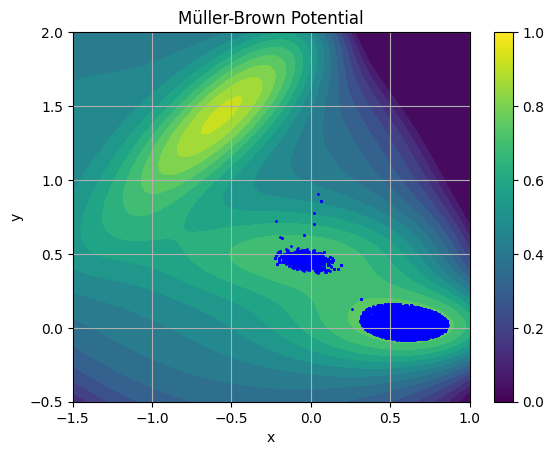

In [44]:
def generate_grid(x1_min, x1_max, x2_min, x2_max, size=100):
    x1 = torch.linspace(x1_min, x1_max, size)
    x2 = torch.linspace(x2_min, x2_max, size)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2, indexing="ij")
    grid = torch.stack([grid_x1, grid_x2], dim=-1)
    x = grid.reshape((-1, 2))
    return x


x1_min, x1_max = -1.5, 1.0
x2_min, x2_max = -0.5, 2.0
grid_size = 100
x_grid = generate_grid(x1_min, x1_max, x2_min, x2_max, grid_size)
fig, axes = plt.subplots()
scale = 0.05
U = compute_Muller_potential(scale, x_grid)
U = U.reshape(100, 100)
U[U > 9] = 9
U = U.T
plt.contourf(
    U,
    levels=np.linspace(-9, 9, 19),
    extent=(x1_min, x1_max, x2_min, x2_max),
    cmap="viridis_r",
)
plt.scatter(samples[:, 0], samples[:, 1], s=1, color='blue')
plt.title('Müller-Brown Potential')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


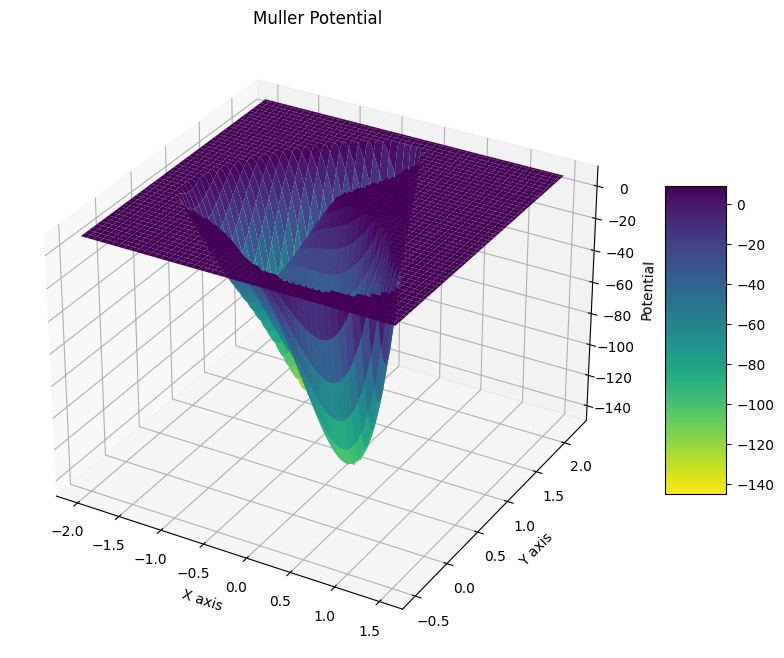

In [45]:
# Generate a grid of points
scale = 1
x = np.linspace(-2, 1.5, 100)
y = np.linspace(-0.5, 2.2, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Compute the Muller potential for each point
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        point = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)
        Z[i, j] = compute_Muller_potential(scale, point)
        
Z[Z > 9] = 9

# Plot the 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis_r', edgecolor='none')
ax.set_title('Muller Potential')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Potential')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()